<a href="https://colab.research.google.com/github/olaidejoseph/g02-sms-spam/blob/master/LSTMSpam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from google.colab import files
#files.upload()

In [2]:
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from keras.optimizers import SGD, Adam, RMSprop



embedding_dim = 100
max_length = 150
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"



In [3]:
data = pd.read_csv('/content/spam.csv', engine='python')
data.dropna(inplace=True,axis=1)
data.rename(columns={"v1":"label","v2":"message"},inplace=True)


In [4]:
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


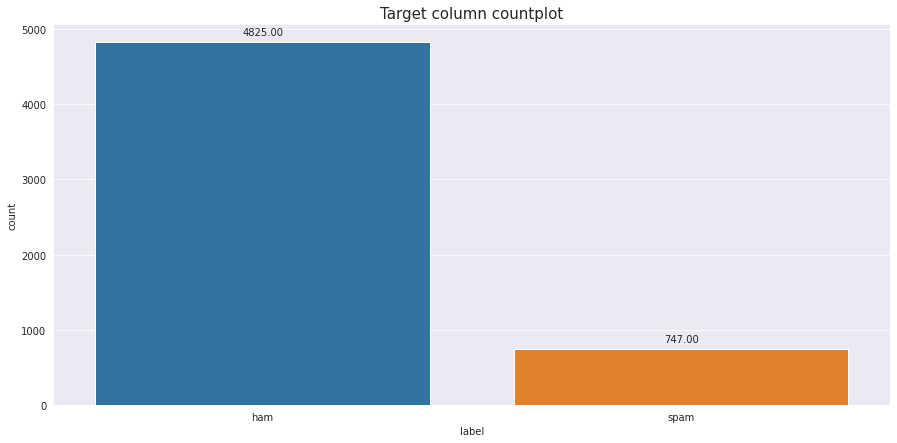

In [5]:
plt.figure(figsize=(15,7))
sns.set_style("darkgrid")
splot = sns.countplot(x="label",data=data)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), \
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.title('Target column countplot', size=15)
plt.show()

The data target is highly imbalance.
Appropriate weight balancing method will be applied to counter the imbalance

# Text Preprocessing

In [6]:
import spacy

In [7]:
nlp = spacy.load('en', disable=['tagger', 'parser', 'ner'])
spacy_stop_words = spacy.lang.en.STOP_WORDS # getting spacy's stop-words

In [8]:
#Stopwords list from https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js
# Convert it to a Python list and paste it here
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [9]:
stop_words = list(set(list(spacy_stop_words) + stopwords))
stopwords = list({word.lemma_.lower() for word in nlp(' '.join(stop_words))})

In [10]:
# defining tokenzer function to tokenize the lower case lemma of documents in a corpus and 
# filter out stop-words  
def tokenizer_spacy(text):
    return [word.lemma_.lower() for word in nlp(text) if word.is_alpha and word.lemma_.lower() not in stopwords]

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold

In [12]:
sentences = data['message']
labels = data['label']

In [13]:
# Label encoding
encode = LabelEncoder()
labels = encode.fit_transform(labels)

In [14]:
senten = [word for word in sentences if word not in stopwords] # stopword filtering

In [15]:
# tokenize (lemmatize and filter stop words) corpus 
senten = [' '.join(tokenizer_spacy(doc)) for doc in senten]

In [16]:
sentences[0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [17]:
senten[0]

'jurong point crazy available bugis n great world la e buffet cine amore wat'

In [18]:
# word tokenizing
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(senten)

word_index = tokenizer.word_index

In [19]:
vocab_size=len(word_index)

# padding and converting to numeric sequence
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [20]:
print(vocab_size)

6155


In [21]:
training_sequences, test_sequences, training_labels, test_labels = train_test_split(padded, labels, test_size=0.25, random_state=1)

# Class weight balancing

In [22]:
from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(labels), class_weight.compute_class_weight('balanced',
                                                 np.unique(labels),
                                                 labels))) 

# Modelling

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 20

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1,
                               min_delta=1e-4)

lrp = tf.keraslrp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.1,
                                   patience=2,
                                   cooldown=2,
                                   verbose=1)

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, class_weight=class_weights, 
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stopping, lrp],
                    verbose=2)

print("Training Complete")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 100)          615600    
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               962400    
_________________________________________________________________
dropout (Dropout)            (None, 600)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 601       
Total params: 1,578,601
Trainable params: 1,578,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
131/131 - 14s - loss: 0.3652 - accuracy: 0.8586 - val_loss: 0.1683 - val_accuracy: 0.9813
Epoch 2/20
131/131 - 13s - loss: 0.1070 - accuracy: 0.9789 - val_loss: 0.0622 - val_accuracy: 0.9878
Epoch 3/20
131/131 - 13s - loss: 0.0524 - 

Evaluation

In [24]:
score = model.evaluate(test_sequences, test_labels, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

44/44 [==============================] - 1s 31ms/step - loss: 0.0822 - accuracy: 0.9828
Test loss: 0.08218560367822647
Test accuracy: 0.9827709794044495


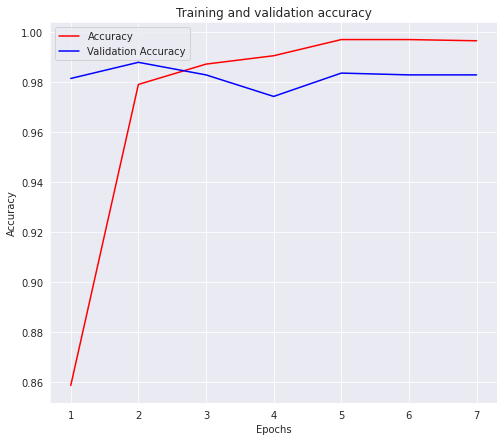

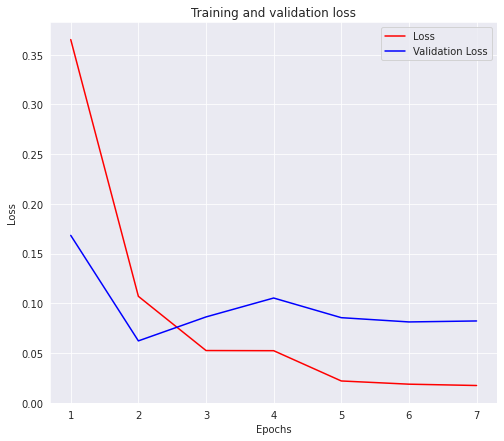

In [25]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1, len(acc)+1) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure(figsize=(8,7))
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize=(8,7))
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])



plt.show()

The best epoch seems to be at 5

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 20

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1,
                               min_delta=1e-4)

lrp = tf.keraslrp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.1,
                                   patience=2,
                                   cooldown=2,
                                   verbose=1)

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=5, 
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stopping, lrp],
                    verbose=2)

print("Training Complete")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          615600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600)               962400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 601       
Total params: 1,578,601
Trainable params: 1,578,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
131/131 - 14s - loss: 0.2294 - accuracy: 0.9237 - val_loss: 0.0909 - val_accuracy: 0.9821
Epoch 2/5
131/131 - 13s - loss: 0.0871 - accuracy: 0.9715 - val_loss: 0.0558 - val_accuracy: 0.9835
Epoch 3/5
131/131 - 13s - loss: 0.0325 - a

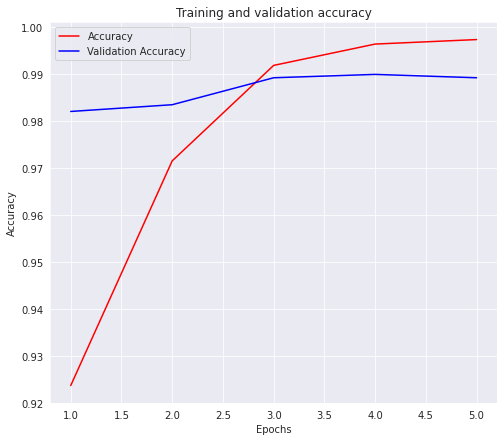

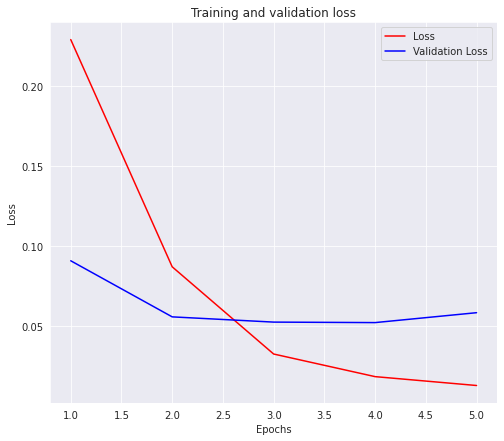

In [27]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1, len(acc)+1) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure(figsize=(8,7))
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize=(8,7))
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.show()


# Prediction and Evaluation

In [28]:
score = model.evaluate(test_sequences, test_labels, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

44/44 [==============================] - 1s 31ms/step - loss: 0.0584 - accuracy: 0.9892
Test loss: 0.058385636657476425
Test accuracy: 0.9892318844795227


In [29]:
y_pred_train = model.predict(training_sequences)
y_pred_test = model.predict(test_sequences)

In [30]:
y_pred_test[4]

array([0.01097369], dtype=float32)

In [31]:
y_pred_train = [int(np.round(i)) for i in y_pred_train]
y_pred_test = [int(np.round(i)) for i in y_pred_test]

In [32]:
y_pred_test[4]

0

In [33]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, roc_auc_score, confusion_matrix, classification_report

In [34]:
print(classification_report(test_labels, y_pred_test, digits=3))

              precision    recall  f1-score   support

           0      0.989     0.998     0.994      1213
           1      0.988     0.928     0.957       180

    accuracy                          0.989      1393
   macro avg      0.989     0.963     0.975      1393
weighted avg      0.989     0.989     0.989      1393



In [35]:
print('Training F1 score: {:.4f}'.format(\
    f1_score(training_labels, y_pred_train)))
      
print('Testing F1 score: {:.4f}'.format(\
    f1_score(test_labels, y_pred_test)))

print('\n')

print('Training precision_score: {:.4f}'.format(\
    precision_score(training_labels, y_pred_train)))
      
print('Testing precision_score: {:.4f}'.format(\
    precision_score(test_labels, y_pred_test)))

Training F1 score: 0.9912
Testing F1 score: 0.9570


Training precision_score: 0.9929
Testing precision_score: 0.9882


Note: the f1 score is taking spam as it's positive class

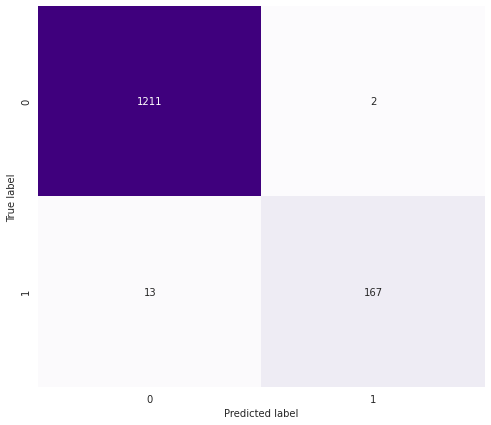

In [36]:
plt.figure(figsize=(8,7))
conf_mat = confusion_matrix(test_labels, y_pred_test)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Purples", cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()